# Cortical Filters
## Visualization of filters and convolutions

In [1]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random


import argparse
import numpy as np
import pydub
import tensorflow as tf

# from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [2]:
save_path = '/scratch0/ilya/locDownloads/advaudio_fig/'

In [3]:
from PIL import Image

In [4]:
import imageio

In [5]:
import importlib

In [6]:
importlib.reload(win)

<module 'windows' from '/cfarhomes/ilyak/ilyakavalerov@gmail.com/ramawks69/pyfst/windows.py'>

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as ipd
import librosa.display

In [7]:
# cortical
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]

winobj = win.cortical_psi_factory(rv, sv, 128)
print(winobj.nfilt)

48


In [9]:
from colorsys import hls_to_rgb

def make_color(M):
    return (M - M.min()) / (M.max() - M.min())

def colorize(z):
    # complex to color
    # https://stackoverflow.com/questions/17044052/mathplotlib-imshow-complex-2d-array/36082859
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    return c

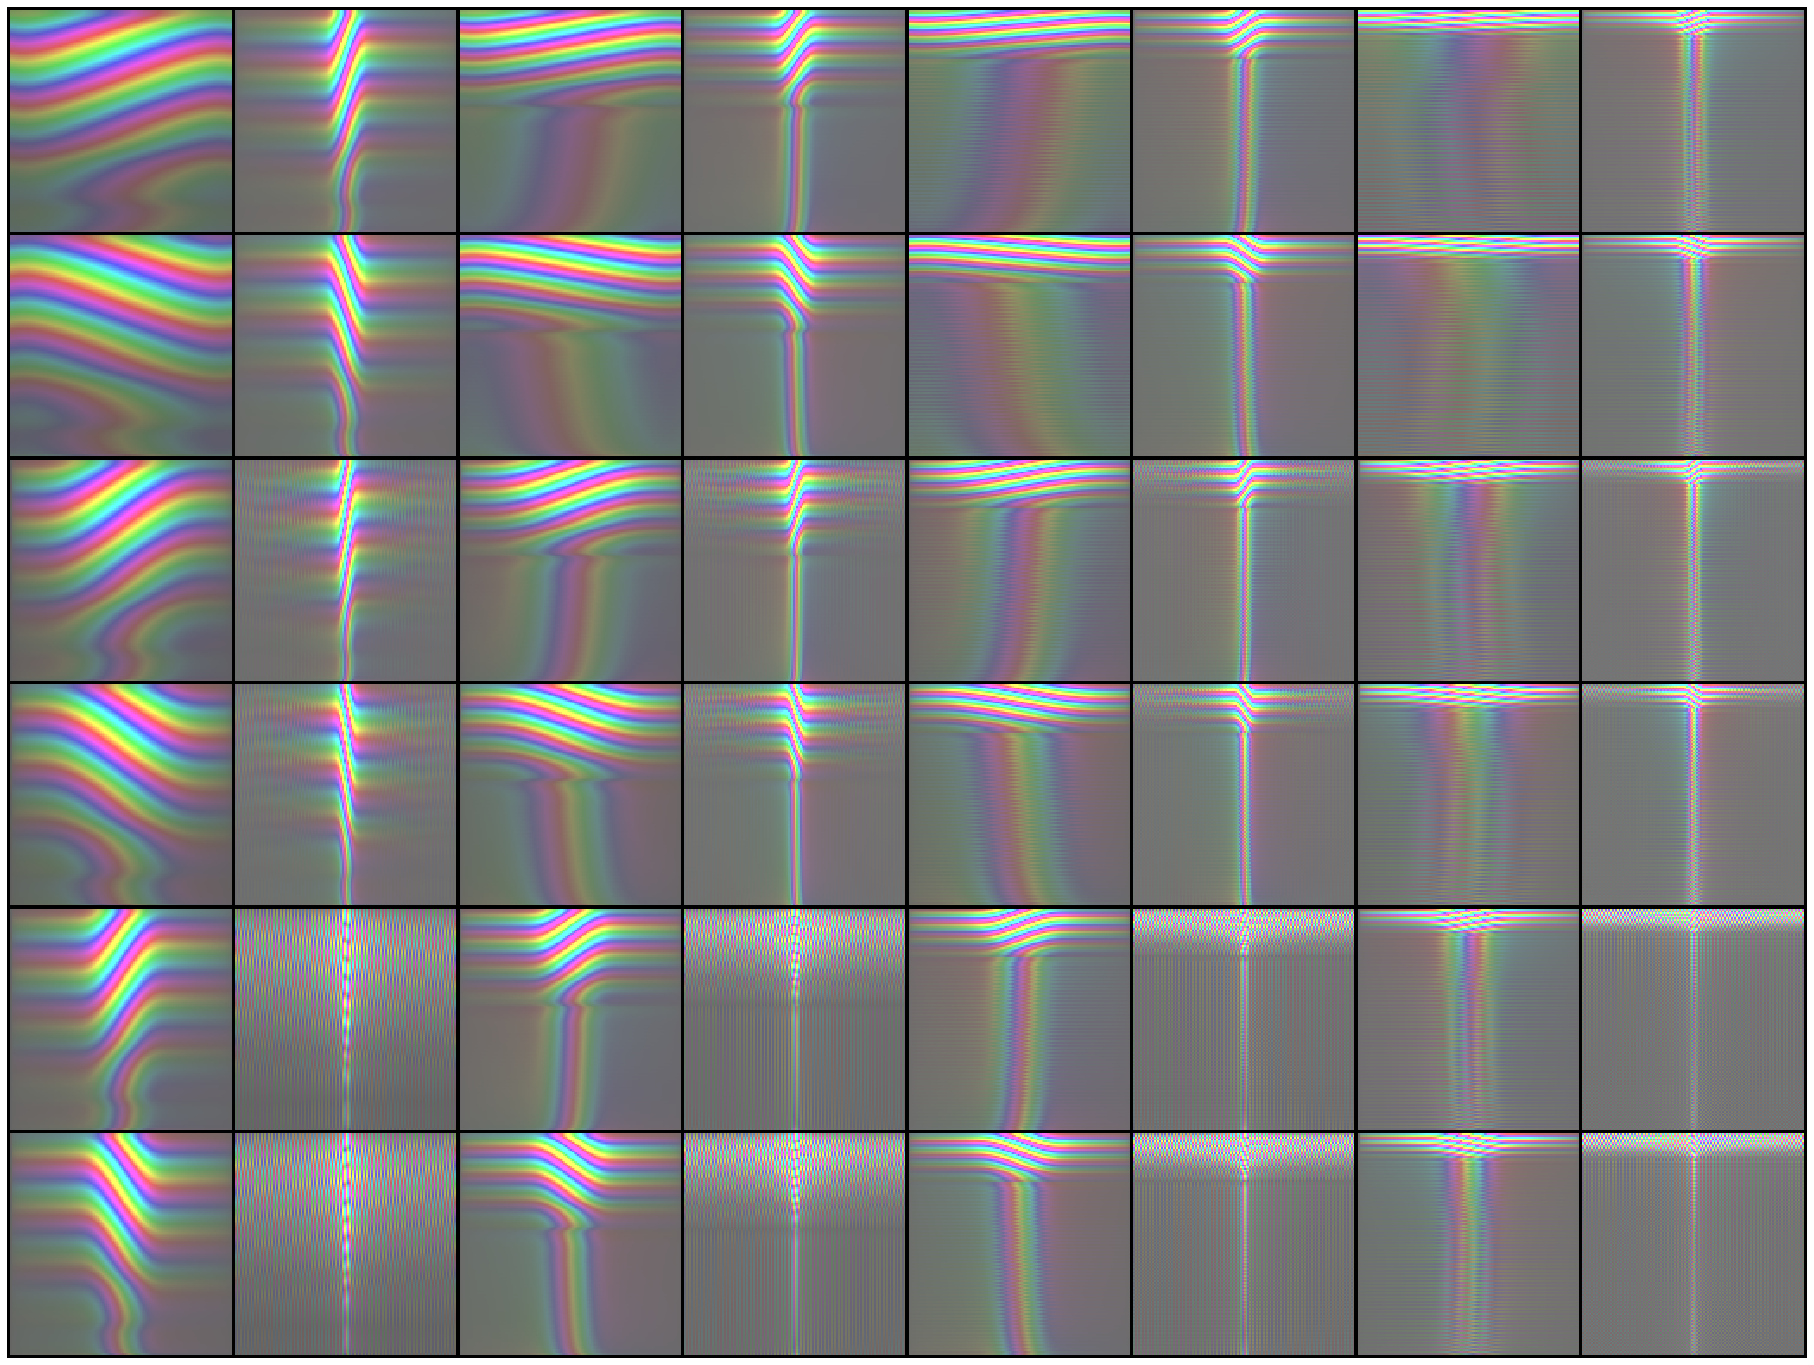

In [11]:

nrow = int(np.sqrt(winobj.nfilt))
leftover = winobj.nfilt % nrow
ncol = winobj.nfilt // nrow
if leftover:
    ncol += 1

img = np.zeros((2+(winobj.kernel_size[0]+2)*nrow, 2+((winobj.kernel_size[1]+2)*ncol), 3))
for col in range(ncol):
    for row in range(nrow):
        idx = col*nrow + row
        if idx < winobj.nfilt:
            filt_ = winobj.filters[:,:,idx]
            tmp_img = colorize(filt_)
            for chan in range(3):
                tmp_img[:,:,chan] = (tmp_img[:,:,chan] - tmp_img[:,:,chan].mean()) / (3*tmp_img[:,:,chan].std())
                tmp_img[:,:,chan] /= 2.0
                tmp_img[:,:,chan] += 0.5
                tmp_img[:,:,chan] = np.clip(tmp_img[:,:,chan], 0, 1)
            img[ (row*(winobj.kernel_size[0]+2)+2):((row+1)*(winobj.kernel_size[0]+2)), (col*(winobj.kernel_size[1]+2)+2):((col+1)*(winobj.kernel_size[1]+2)) ] = \
                tmp_img

fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.imshow(img)

In [12]:
# iterate in cortical specific way
# 6 x 4, left and right

nrow = 6
ncol = 4

img = np.zeros((2+(winobj.kernel_size[0]+2)*nrow, 2+((winobj.kernel_size[1]+2)*(ncol*2)), 3))
for left_right in range(2):
    for col in range(ncol):
        for row in range(nrow):
            idx = 2*row + col*12 + left_right # even is phase 1
            if left_right == 0:
                x = col
            else:
                x = col + left_right*4
            y = row
            # print('{}x{} is {}'.format(y, x, winobj.filter_params[idx]))
            filt_ = winobj.filters[:,:,idx]
            tmp_img = colorize(filt_)
#             tmp_img = np.expand_dims(np.angle(filt_),-1)
            for chan in range(tmp_img.shape[2]):
                tmp_img[:,:,chan] = (tmp_img[:,:,chan] - tmp_img[:,:,chan].mean()) / (3*tmp_img[:,:,chan].std())
                tmp_img[:,:,chan] /= 2.0
                tmp_img[:,:,chan] += 0.5
                tmp_img[:,:,chan] = np.clip(tmp_img[:,:,chan], 0, 1)
            img[ (y*(winobj.kernel_size[0]+2)+2):((y+1)*(winobj.kernel_size[0]+2)), (x*(winobj.kernel_size[1]+2)+2):((x+1)*(winobj.kernel_size[1]+2)) ] = \
                tmp_img
            


In [14]:
imageio.imsave(save_path + 'cortical_color2.png', img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
# img_ =  Image.fromarray(np.uint8(img*255))
# img_.putalpha(500)

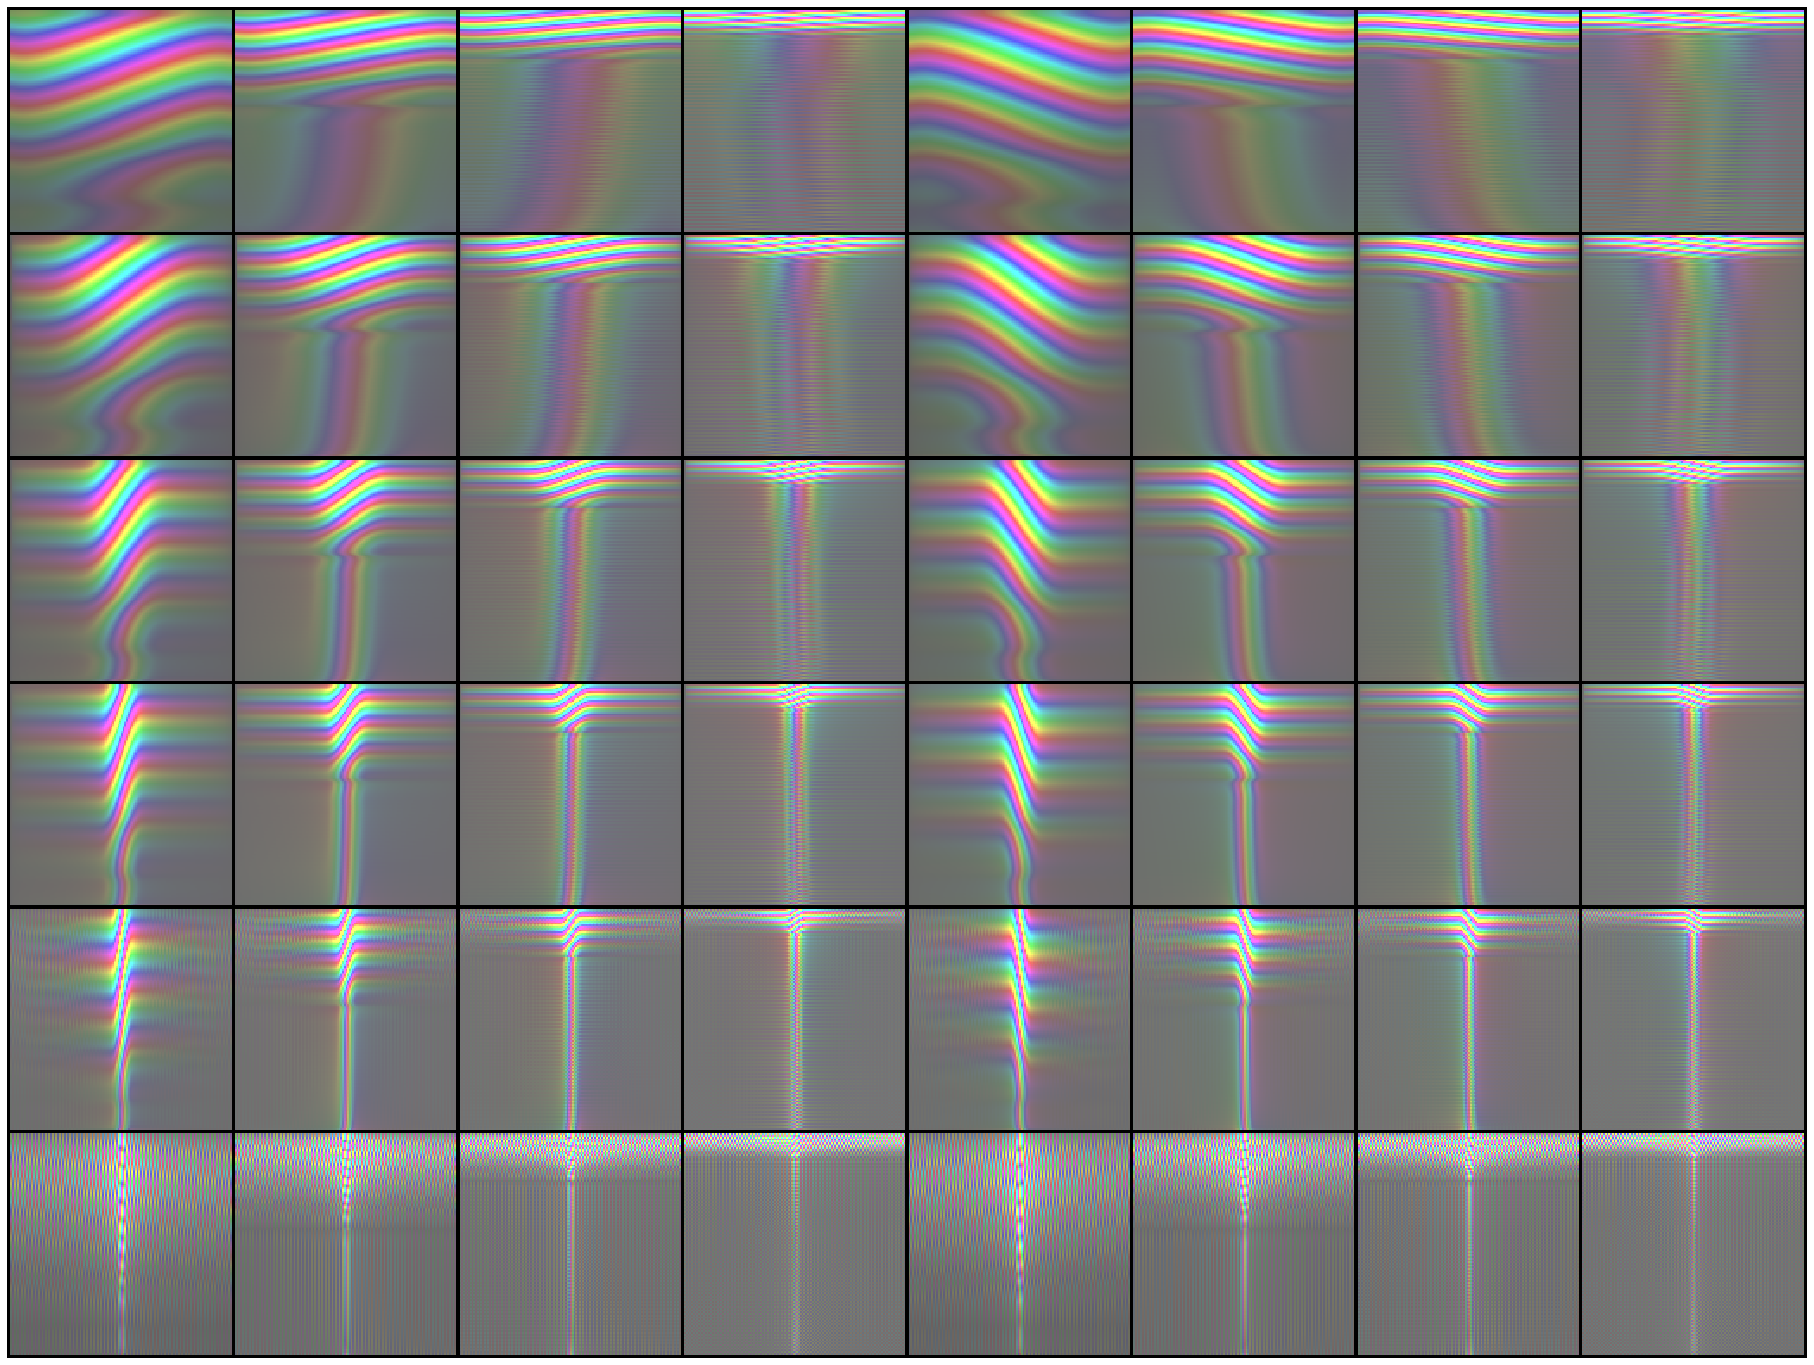

In [13]:
fig = plt.figure()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
fig.set_figheight(25)
fig.set_figwidth(25)
plt.imshow(img)
# plt.imshow(img[:,:,0], cmap='Greys')

In [10]:
layerO = namedtuple('layerO', ['strides', 'padding'])

### Load data

In [11]:
tfrecord_file = '/scratch1/ilya/locDoc/data/alexa/v7.18/val_40800_positive_x1/_clean_speech_00_0000.tfrecord'

In [12]:
spec_h = 256 # 80
examples = []
specs = []
spec_labs = []
audio_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    audio_labs.append(eg_np.features.feature["audio_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break
spec_labs = np.array(spec_labs)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [45]:
# or load adv examples
npzfile = np.load('/scratch1/ilya/locDoc/experiments/adv_egs/fgd_adv_eg_2.npz')
specs = np.array([npzfile['clean_feat'], npzfile['adv_feat'], npzfile['clean_feat']-npzfile['adv_feat']])
print(specs.shape)

(3, 257, 124)


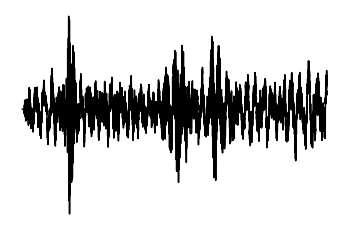

In [13]:
plt.plot(y, color='black')
plt.axis('off')
plt.savefig(save_path + 'wav.png', dpi=600)

In [16]:
from librosa.filters import mel

In [73]:
# def imgify_spec(img):
#     # for bw image, black-hot
#     img = (img - img.mean()) / (4*img.std())
#     img /= 2
#     img += 0.5
#     return 1-np.clip(img, 0, 1)

cm_hot = mpl.cm.get_cmap('afmhot')
def imgify_spec(img):
    # for hot image
    img = (img - img.mean()) / (8*img.std())
#     img /= 2
    img += 0.2
    img = np.clip(img, -1, 1)
    return cm_hot(img)

In [74]:
spec = np.abs(librosa.core.stft(np.array(y) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=1024))
A = mel(16000, 1024, n_mels=256)
lfbe = np.dot(A,spec)**0.3
img = lfbe
plt.imshow(imgify_spec(lfbe))

#imageio.imsave(save_path + 'lfbe.png', imgify_spec(lfbe))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


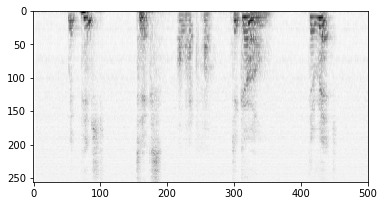

In [63]:
spec = np.abs(librosa.core.stft(np.array(y) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=1024))
A = mel(16000, 1024, n_mels=256)
lfbe = np.dot(A,spec)
plt.imshow(lfbe**0.3, cmap='Greys')

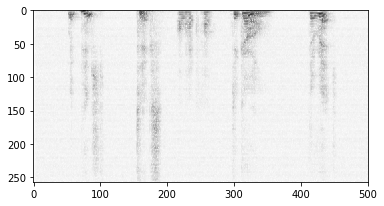

In [59]:
spec = np.abs(librosa.core.stft(np.array(y) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=512))
plt.imshow(spec**0.3, cmap='Greys')

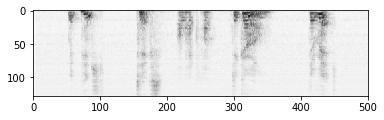

In [60]:
spec = np.abs(librosa.core.stft(np.array(y) / 2.0**15,
        win_length=400,
        hop_length=160,
        n_fft=512))
A = mel(16000, 512, n_mels=128)
lfbe = np.dot(A,spec)
plt.imshow(lfbe**0.3, cmap='Greys')

## CPU convolution

In [13]:
from scipy.signal import convolve2d

In [19]:
res = convolve2d(specs[0], winobj.filters[10])

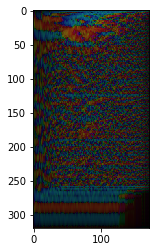

In [20]:
plt.imshow(colorize(res.T))

## Tensorflow Convolution

In [18]:
rv = [4, 8, 16, 32]
sv = [.25, .5, 1, 2, 4, 8]
ncort = len(rv) + 2*len(sv)
l = 32
psi = win.cortical_psi_factory(rv, sv, l)
nrate = len(rv)
nscale = 2*len(sv)
layer_params = layerO((1,1), 'same')

In [19]:
# define the operations
input_spec = tf.placeholder(tf.float32, shape=(1,256,256))
x = tf.expand_dims(input_spec, -1) # batch, freq, time, 1

U1 = scat2d(x, psi, layer_params)
h = U1.shape[1]
w = U1.shape[2]
### bs, h, w, time varying, frequency varying
U1 = tf.reshape(U1, [-1, h, w, nrate, nscale])
### bs, time varying, frequency varying, h, w
U1 = tf.transpose(U1, [0,3,4,1,2])

# rategram is max over scale varying
rategram = tf.layers.max_pooling3d(U1, (1,nscale,1), (1,nscale,1), padding='same')
rategram = tf.reshape(rategram, [-1, nrate, h, w])
# scalegram is max over rate varying
scalegram = tf.layers.max_pooling3d(U1, (nrate,1,1), (nrate,1,1), padding='same')
scalegram = tf.reshape(scalegram, [-1, nscale, h, w])

cortical = tf.concat([rategram, scalegram], axis=1)
cortical = tf.transpose(cortical, [0,2,3,1])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling3D instead.


In [20]:
cortical.shape

TensorShape([Dimension(1), Dimension(256), Dimension(256), Dimension(16)])

In [21]:
sess = tf.Session()

In [22]:
sess.run(tf.global_variables_initializer())

In [23]:
feed_dict = {input_spec: [lfbe]}

In [35]:
cortical_np = sess.run(scalegram, feed_dict)

In [36]:
cortical_np.shape

(1, 12, 256, 256)

In [76]:
cortical_np = sess.run(U1, feed_dict)
for t in range(4):
    for f in range(6):
        print('.', end='')
        img = cortical_np[0,t,(2*f) + 0,:,:]
        imageio.imsave(save_path + 'cortical_{}x{}_phase0.png'.format(t, f), imgify_spec(img))
        print('.', end='')
        img = cortical_np[0,t,(2*f) + 1,:,:]
        imageio.imsave(save_path + 'cortical_{}x{}_phase-1.png'.format(t, f), imgify_spec(img))
        

# cortical_np = sess.run(rategram, feed_dict)
# for t in range(4):
#     print('.', end='')
#     img = cortical_np[0,t,:,:]
#     imageio.imsave(save_path + 'rategram_{}.png'.format(t, f), imgify_spec(img))

# cortical_np = sess.run(scalegram, feed_dict)
# for t in range(12):
#     print('.', end='')
#     img = cortical_np[0,t,:,:]
#     imageio.imsave(save_path + 'scalegram_{}.png'.format(t, f), imgify_spec(img))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


.

................

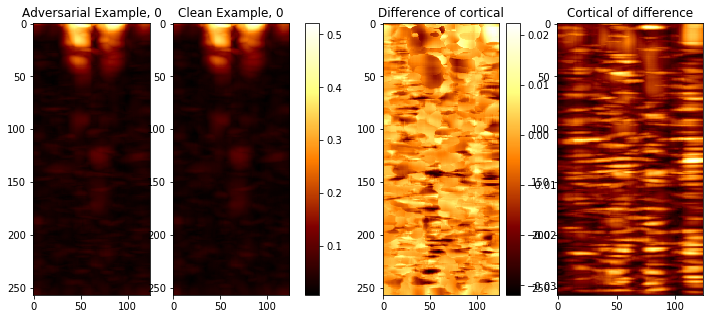

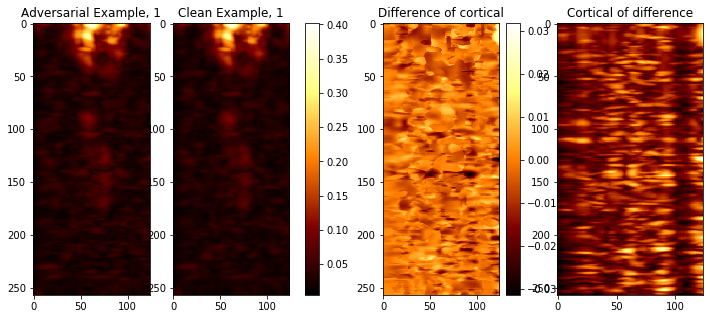

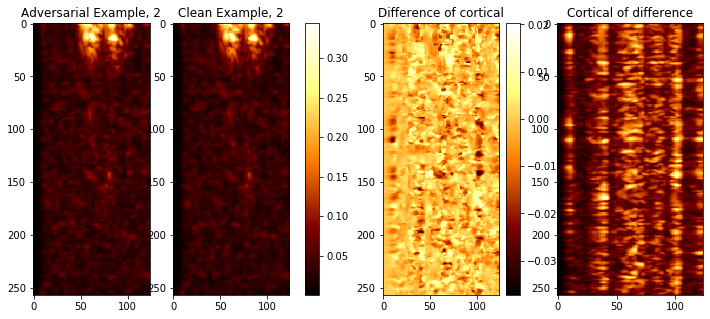

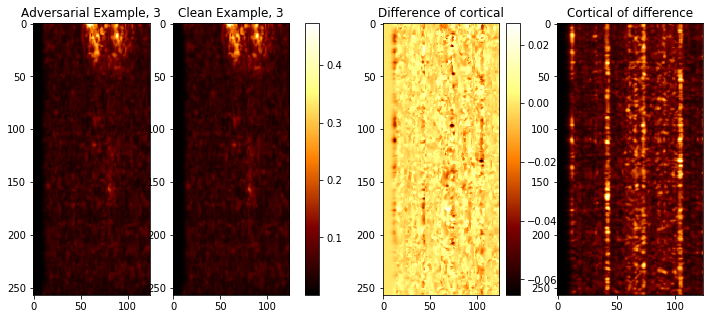

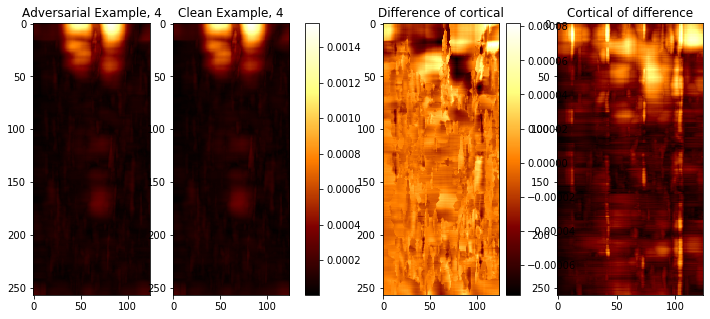

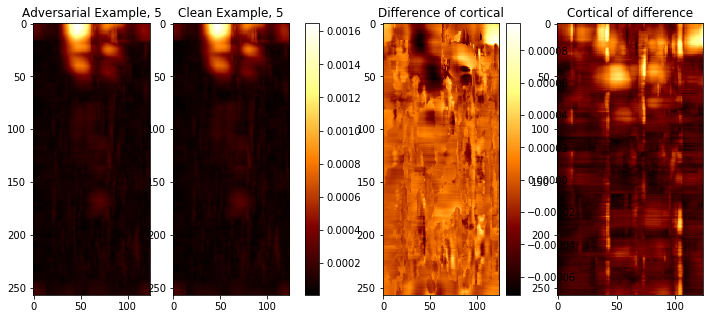

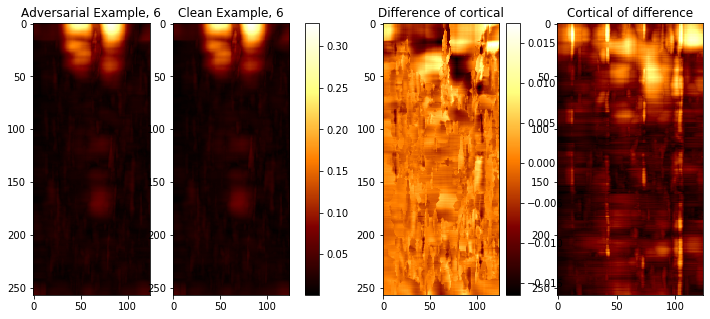

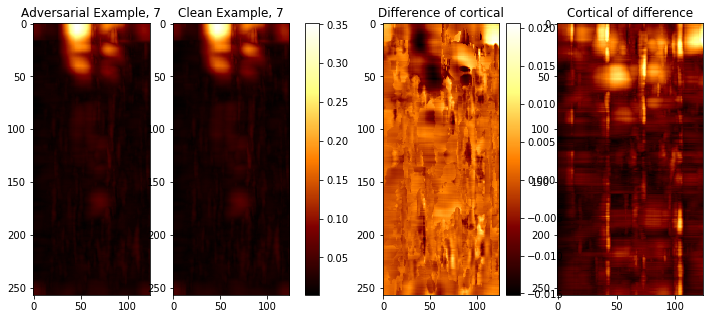

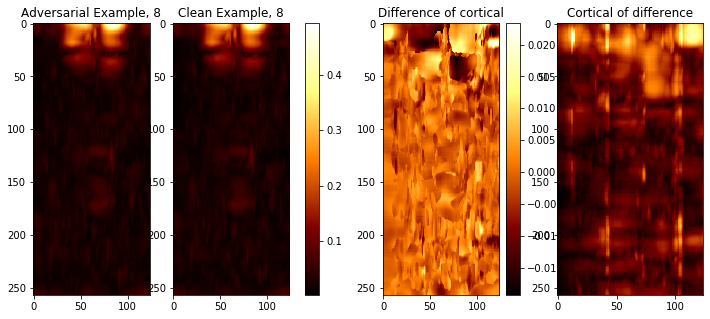

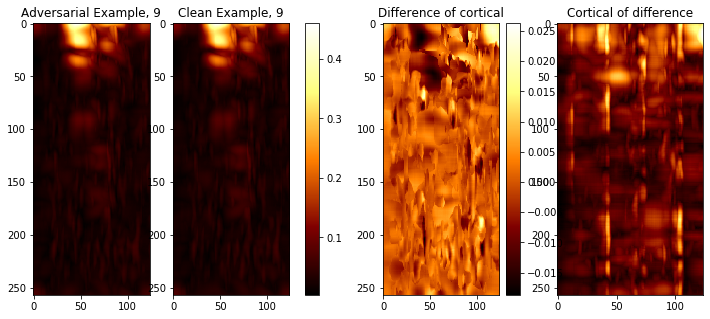

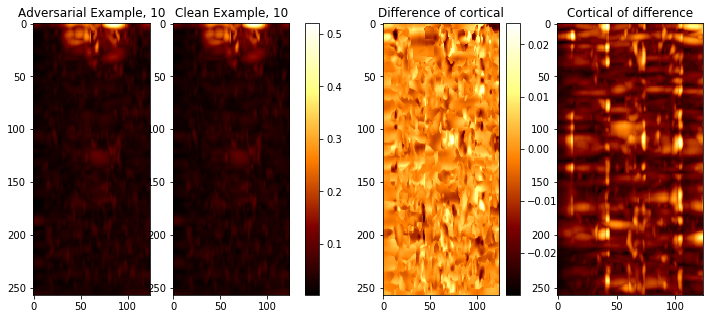

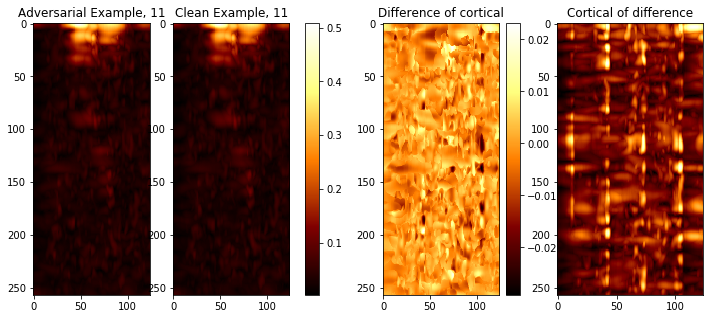

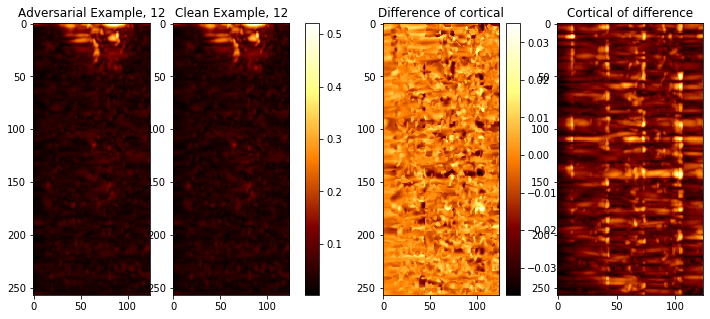

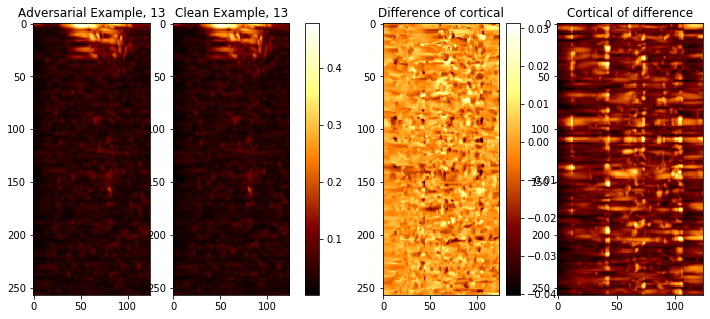

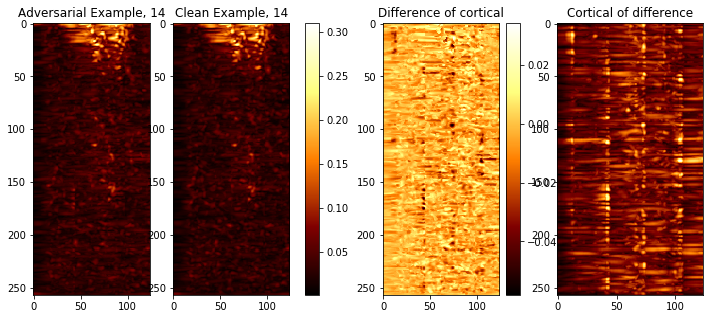

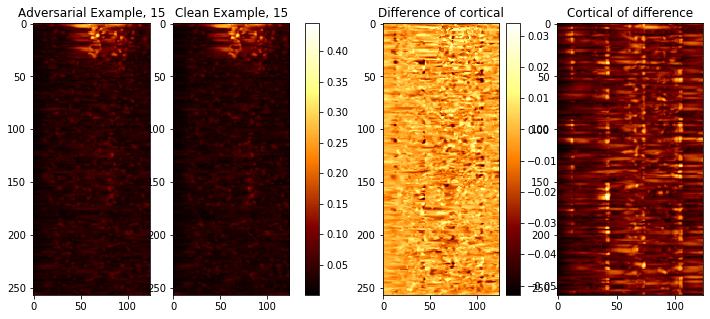

In [77]:
cort_i = 13
color_name = 'afmhot'
for cort_i in np.arange(cortical_np.shape[3]):
    print('.', end='')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,5))
    ax1.imshow( cortical_np[1,:,:,cort_i], aspect='auto', cmap=color_name, vmin=cortical_np[:2,:,:,cort_i].min(), vmax=cortical_np[:2,:,:,cort_i].max())
    ax1.set_title("Adversarial Example, %i" % cort_i)
    ax1.grid(False)
    im = ax2.imshow( cortical_np[0,:,:,cort_i], aspect='auto', cmap=color_name, vmin=cortical_np[:2,:,:,cort_i].min(), vmax=cortical_np[:2,:,:,cort_i].max())
    ax2.set_title("Clean Example, %i" % cort_i)
    ax2.grid(False)

    cax,kw = mpl.colorbar.make_axes([ax for ax in (ax1, ax2)])
    plt.colorbar(im, cax=cax, **kw)

    diff = cortical_np[0,:,:,cort_i] - cortical_np[1,:,:,cort_i]
    im3 = ax3.imshow( diff, aspect='auto', cmap=color_name, vmin=diff.min(), vmax=diff.max())
    ax3.set_title("Difference of cortical")
    ax3.grid(False)

    cax,kw = mpl.colorbar.make_axes([ax3])
    plt.colorbar(im3, cax=cax, **kw)

    diff = cortical_np[2,:,:,cort_i] - cortical_np[1,:,:,cort_i]
    im4 = ax4.imshow( cortical_np[2,:,:,cort_i], aspect='auto', cmap=color_name, vmin=cortical_np[2,:,:,cort_i].min(), vmax=cortical_np[2,:,:,cort_i].max())
    ax4.set_title("Cortical of difference")
    ax4.grid(False)

    plt.savefig(os.path.join('/scratch0/ilya/locDownloads/cortical_fgd_demo', 'comparison_%i.png' % cort_i) )